In [3]:
# General Imports
import numpy as np
import pandas as pd
from collections import Counter

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

In [4]:
vowel = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/vowel-context.data'

In [5]:
#Vowel dataset we select the fist and the second vowel
vowel_data = pd.read_csv(vowel,skiprows=2, index_col=False,delim_whitespace=True)
vowel_data.columns = ['feature{}'.format(i) for i in range(0,vowel_data.shape[1])]

vowel_data.shape,vowel_data.nunique().tolist()[-1:]

((987, 14), [11])

In [10]:
#vowel1_dataset.query('feature13 == True')
vowel1_dataset = vowel_data.copy()
vowel1_dataset['feature13']= (vowel1_dataset['feature13']==1)
vowel1_dataset = vowel1_dataset.drop(vowel1_dataset[vowel1_dataset['feature13'] == False].sample(frac=0.96).index)
vowel1_dataset.shape

(125, 14)

In [13]:
X = np.array(vowel1_dataset.iloc[: , :-1])
y = np.array(vowel1_dataset.iloc[: , -1:].astype(int))


In [14]:
# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(
     X, y, test_size=0.2, random_state=22)

# Reduce dimensions (the dataset now has a dimensionality of 31 attributes)
n_dim = 13 #number of qubits we want to use
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [15]:
print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[-0.39322976  0.6053539  -0.76858786 -0.26009067 -0.07461199 -0.22404617
 -0.29787192  0.23080176 -0.32122001  0.45241786 -0.26275635 -0.07066858
  0.37891289] [1]
[ 0.04513998 -1.         -0.2140633  -0.92848571  0.32334025  0.15926126
  0.0856235  -0.28793075 -0.33857458 -0.01537349 -0.23196284  0.36211106
  0.85129546] [1]


With our training and testing datasets ready, we set up the QuantumKernel class with the ZZFeatureMap, and use the BasicAer statevector_simulator to estimate the training and testing kernel matrices.

In [16]:
zz_map = ZZFeatureMap(feature_dimension=13, reps=2, entanglement='linear', insert_barriers=True)

zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

Let's calculate the transition amplitude between the first and second training data samples, one of the entries in the training kernel matrix.

Let's createe a circuit for the first sample and try to simulate

In [17]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
#zz_circuit.decompose().decompose().draw(output='mpl')

We then simulate the circuit. We will use the `qasm_simulator` since the circuit contains measurements, but increase the number of shots to reduce the effect of sampling noise.

In [18]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

This process is then repeated for each pair of training data samples to fill in the training kernel matrix, and between each training and testing data sample to fill in the testing kernel matrix. Note that each matrix is symmetric, so to reduce computation time, only half the entries are calculated explictly. 

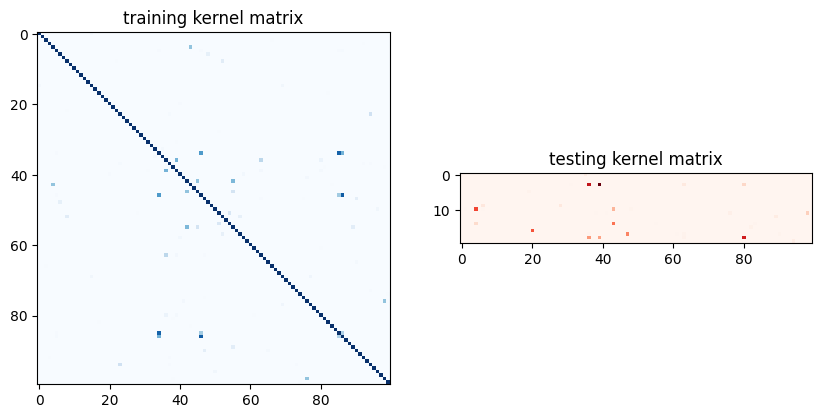

In [19]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

The `scikit-learn` `svc` algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the `QuantumKernel` class in Qiskit.

The following code takes the training and testing kernel matrices we calculated earlier and  provides them to the `scikit-learn` `svc` algorithm:

In [20]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, label_train)
zzpc_score = zzpc_svc.score(matrix_test, label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 0.75


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The following code gives the kernel as a callable function:

In [21]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)

print(f'Callable kernel classification test score: {zzcb_score}')

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


Callable kernel classification test score: 0.75


In [22]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

linear kernel classification test score:  0.95
poly kernel classification test score:  1.00
rbf kernel classification test score:  1.00
sigmoid kernel classification test score:  0.90


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam